In [111]:
import pacepredictor as pp
import importlib
import plotly.express as px
import pandas as pd
import numpy as np
import missingno as msno
import math
import statsmodels.formula.api as smf

importlib.reload(pp)

<module 'pacepredictor' from '/home/adam/projects/Concept2-Pace-Predictor/pacepredictor.py'>

In [112]:
file_path = "./"
file_name = "cleaned_data.csv"

pp_row = pp.Predictor(f"{file_path}{file_name}", random_state=42)

pp_row.df

result_1  result_100  result_1000  result_10000  result_100000  \
0           NaN         NaN        255.9           NaN            NaN   
1           NaN         NaN          NaN           NaN            NaN   
2         330.0         NaN          NaN           NaN            NaN   
3           NaN         NaN        203.9        2222.6            NaN   
4           NaN         NaN        236.3        2512.3            NaN   
...         ...         ...          ...           ...            ...   
60688       NaN         NaN          NaN           NaN            NaN   
60689       NaN         NaN        230.4           NaN            NaN   
60690       NaN         NaN        177.0           NaN            NaN   
60691       NaN         NaN          NaN        3202.8            NaN   
60692       NaN         NaN          NaN        2571.6            NaN   

       result_2000  result_21097  result_30  result_4  result_42195  \
0              NaN           NaN        NaN       NaN           NaN   
1              NaN           NaN        NaN       NaN           NaN   
2              NaN        5688.1        NaN       NaN           NaN   
3            416.4           NaN     8215.0       NaN           NaN   
4            474.1           NaN     7289.0    1031.0           NaN   
...            ...           ...        ...       ...           ...   
60688          NaN           NaN        NaN       NaN           NaN   
60689          NaN           NaN        NaN       NaN           NaN   
60690          NaN           NaN        NaN       NaN           NaN   
60691          NaN           NaN        NaN       NaN           NaN   
60692          NaN           NaN        NaN       NaN           NaN   

       result_500  result_5000  result_60  result_6000  age  height  weight  \
0             NaN          NaN        NaN          NaN   67     NaN    64.9   
1           116.0          NaN        NaN          NaN   62     NaN    72.6   
2             NaN          NaN        NaN       1498.0   65   172.7    99.8   
3            94.6       1086.8    16144.0       1307.6   56   188.0    97.1   
4           107.4       1204.7        NaN       1485.8   67     NaN    86.2   
...           ...          ...        ...          ...  ...     ...     ...   
60688         NaN       1304.7        NaN          NaN   46     NaN     NaN   
60689         NaN          NaN        NaN          NaN   17     NaN     NaN   
60690         NaN          NaN        NaN          NaN   22     NaN     NaN   
60691         NaN          NaN        NaN          NaN   38     NaN     NaN   
60692         NaN          NaN        NaN          NaN   43   185.4    86.2   

      weight_class gender  
0                H      F  
1                H      F  
2                H      M  
3                H      M  
4                H      M  
...            ...    ...  
60688            H      M  
60689            H      F  
60690            H      M  
60691            H      F  
60692            H      M  

[59910 rows x 19 columns]

# Pick Parameters

There are very few profiles that have a complete set of parameters,and for a useful predictor, we don't want an athlete to have to complete every other test. We will keep all the other parameters which are not event results..

Ideally we choose shorter tests that athletes can complete easily, but that we also have a good amount of data for.



In [113]:
pp.percent_complete(pp_row.df)

result_1          14.236355
result_100         9.752963
result_1000       24.414956
result_10000      32.500417
result_100000      0.302120
result_2000       42.487064
result_21097      13.463529
result_30         34.670339
result_4           7.217493
result_42195       4.221332
result_500        21.106660
result_5000       45.182774
result_60         11.625772
result_6000       15.957269
age              100.000000
height            50.652646
weight            55.606743
weight_class     100.000000
gender           100.000000
dtype: float64


We will choose two tests:
- 1000m (result_1000)
- 1 minute (result_1)

Drop rows where we are missing data, and columns we are not using:

In [114]:
target = ["result_2000"]
predictor_results = ["result_1", "result_1000"]
core_columns = ["age", "height", "weight", "weight_class", "gender"]

columns = target + predictor_results + core_columns

pp_row.df = pp_row.df[columns]

#drop nulls
indexes_to_drop = []
for col in columns:
    indexes_to_drop_temp = pp_row.df[pp_row.df[col].isnull()].index.to_list()
    #if len(indexes_to_drop_temp) > 0:
    indexes_to_drop += indexes_to_drop_temp

pp_row.df = pp_row.df.drop(indexes_to_drop)

How big is our dataset now?

In [115]:
len(pp_row.df)

2553

In [116]:
target = "result_2000"
cont_parameters = predictor_results + ["age", "height", "weight"]
fig = pp_row.plot_scatters(target, cont_parameters, cols=3, height=1500)
fig.show()

# Variable Correlation

In [117]:
fig = px.imshow(pp_row.df[cont_parameters + ["result_2000"]].corr(), title="Correlation heatmap of numerical values")
fig.update_layout(height=800)
fig.show()

All the result parameters are highly correlated, to be expected. We will see how this affects the model but we may need to drop one of the predictor result parameters.

Height and weight also strongly correlated with eachother and results.

Let's put some solid figures on this, and calculate the VIF for each numeric variable.

In [118]:
for parameter in cont_parameters:
    formula_parameters = cont_parameters.copy()
    formula_parameters.remove(parameter)
    formula = f"{parameter} ~ {' + '.join(formula_parameters)}"
    model = smf.ols(formula=formula, data=pp_row.df).fit()
    print(f"{parameter} : VIF = {1 / (1- model.rsquared)}")


result_1 : VIF = 4.425033627605597
result_1000 : VIF = 4.226773314230656
age : VIF = 1.1431120409798177
height : VIF = 2.110796108910415
weight : VIF = 1.6569707865486574


Everything well below 10, two result variables just over 4. This is probably ok.

# Split Data

Need a train, validation and test set.

70% training data. 15% test and 15% validate

In [119]:
pp_row.split_data()

print("Train: " + str(len(pp_row.df_train)))
print("Val: " + str(len(pp_row.df_test)))
print("Test: " + str(len(pp_row.df_val)))

Train: 1787
Val: 383
Test: 383


# Linear Regression

In [120]:
pp_row.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2553 entries, 10 to 60451
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   result_2000   2553 non-null   float64
 1   result_1      2553 non-null   float64
 2   result_1000   2553 non-null   float64
 3   age           2553 non-null   int64  
 4   height        2553 non-null   float64
 5   weight        2553 non-null   float64
 6   weight_class  2553 non-null   object 
 7   gender        2553 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 179.5+ KB


linear


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1680.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:16   Log-Likelihood:                -7996.0
No. Observations:                1787   AIC:                         1.601e+04
Df Residuals:                    1779   BIC:                         1.605e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           265.0040 

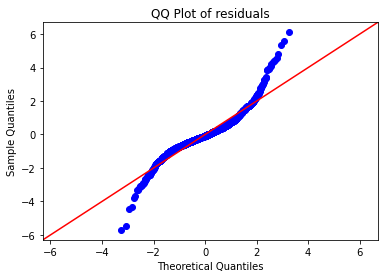


Mean squared error: 489.8s
Mean error: 22.1s

Max p: weight_class[T.L] p=0.707


In [121]:
target = "result_2000"


def do_linear_regression(predictor, model_name, target, order=1, drop=[], intercept=True):
    print(model_name + "\n\n")
    parameters = predictor.df.columns.drop(target).to_list()
    predictor.add_model(model_name, target, parameters,order, drop=drop, intercept=intercept)
    print(predictor.models[model_name].model.summary())

    fig = predictor.models[model_name].plot_residuals()
    fig.show()
    pp_row.models[model_name].plot_QQ()

    print(f"\nMean squared error: {round(predictor.models[model_name].mse,1)}s")
    print(f"Mean error: {round(np.sqrt(predictor.models[model_name].mse),1)}s\n")
    pp_row.models[model_name].p_max()

model_name = "linear"
do_linear_regression(pp_row, model_name, target)


Weight class is contributing very little to the reduction in sum of squares, and has a high p. It will be highly correlated to weight (by definition) so we are probably best dropping this.

In [122]:
pp_row.df.drop("weight_class", axis=1, inplace=True)

linear_2


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1961.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:17   Log-Likelihood:                -7996.1
No. Observations:                1787   AIC:                         1.601e+04
Df Residuals:                    1780   BIC:                         1.604e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     266.7838     20.699     1

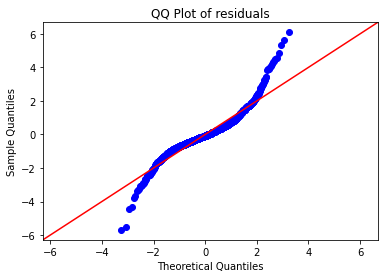


Mean squared error: 488.7s
Mean error: 22.1s

Max p: gender[T.M] p=0.041


In [123]:
model_name = "linear_2"
do_linear_regression(pp_row, model_name, target)

In [124]:
px.histogram(pp_row.models["linear_2"].df_train["residuals"])

Removing weight_class hasn't made a difference to our R^2 or model performance.

All p-values now under our alpha=0.05 threshold and this model is complete, though our residuals do not look normal - perhaps a linear model is not a good a fit.

Interpretation:

- Being male decreases your 2km time.
- The higher your 1 minute score, the lower your 2km time.
- The lower your 1km time, the lower your 2km time.
- Being younger decreases your 2km time.
    - Rowers tend to peak in late 20s/early 30s, so would actually expect this to be a curve, given the limits of this model this result makes sense
- Being taller decreases your 2km time.
- Being lighter decreases your 2km time.
    - not expected, possibly because very trained lightweights are outperforming unfit heavyweight rowers



# Linear Regression with Polynomial Terms

## 2nd Order

2nd_order


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1080.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:17   Log-Likelihood:                -7986.5
No. Observations:                1787   AIC:                         1.600e+04
Df Residuals:                    1775   BIC:                         1.606e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       369.5877    160.98

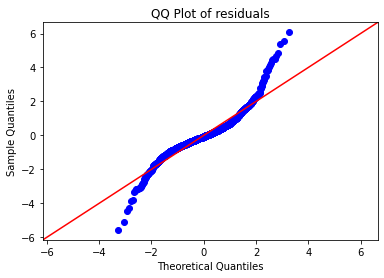


Mean squared error: 475.0s
Mean error: 21.8s

Max p: weight_2 p=0.821


In [125]:
model_name = "2nd_order"
do_linear_regression(pp_row, model_name, target, order=2)

Ever so slightly improved R^2. Much worse performance. Residuals unchanged. We'll backwards selection on this model but will need to revist the residuals.

Drop highest p:

2nd_order_2


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1189.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:18   Log-Likelihood:                -7986.6
No. Observations:                1787   AIC:                         1.600e+04
Df Residuals:                    1776   BIC:                         1.606e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       362.5679    157.

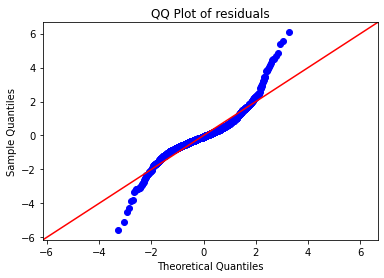


Mean squared error: 475.7s
Mean error: 21.8s

Max p: height_2 p=0.494


In [126]:
model_name = "2nd_order_2"
drop = ["weight_2"]

do_linear_regression(pp_row, model_name, target, order=2, drop=drop)

2nd_order_3


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1321.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:18   Log-Likelihood:                -7986.8
No. Observations:                1787   AIC:                         1.599e+04
Df Residuals:                    1777   BIC:                         1.605e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       257.8086     37.

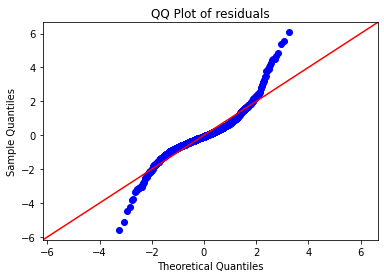


Mean squared error: 474.5s
Mean error: 21.8s

Max p: age p=0.126


In [127]:
model_name = "2nd_order_3"
drop += ["height_2"]

do_linear_regression(pp_row, model_name, target, order=2, drop=drop)

2nd_order_4


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1485.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:19   Log-Likelihood:                -7988.0
No. Observations:                1787   AIC:                         1.599e+04
Df Residuals:                    1778   BIC:                         1.604e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       247.8062     37.

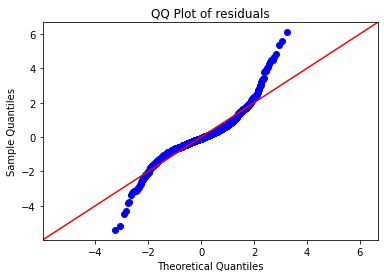


Mean squared error: 477.2s
Mean error: 21.8s

Max p: gender[T.M] p=0.047


In [128]:
model_name = "2nd_order_4"
drop += ["age"]

do_linear_regression(pp_row, model_name, target, order=2, drop=drop)

All p > alpha. Model performance about the same, residuals still not normal.

## 3rd Order

3rd_order


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     754.7
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:19   Log-Likelihood:                -7971.7
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1770   BIC:                         1.607e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4337.9823   1794.24

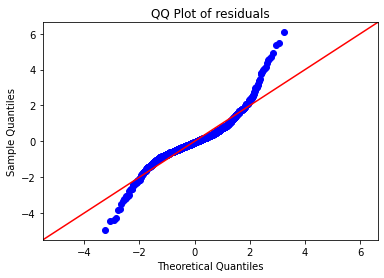


Mean squared error: 480.0s
Mean error: 21.9s

Max p: result_1000 p=0.665


In [129]:
model_name = "3rd_order"
drop = []

do_linear_regression(pp_row, model_name, target, order=3, drop=drop)

3rd_order_2


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     805.3
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:20   Log-Likelihood:                -7971.8
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1771   BIC:                         1.606e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4212.8165   1770.

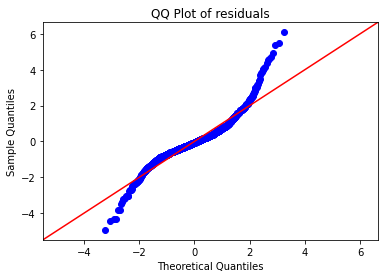


Mean squared error: 479.4s
Mean error: 21.9s

Max p: gender[T.M] p=0.196


In [130]:
model_name = "3rd_order_2"
drop += ["result_1000"]

do_linear_regression(pp_row, model_name, target, order=3, drop=drop)

3rd_order_3


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     862.4
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:21   Log-Likelihood:                -7972.7
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1772   BIC:                         1.606e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4175.4582   1770.

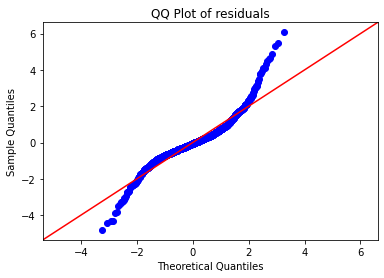


Mean squared error: 480.3s
Mean error: 21.9s

Max p: result_1 p=0.131


In [131]:
model_name = "3rd_order_3"
drop += ["gender"]

do_linear_regression(pp_row, model_name, target, order=3, drop=drop)

3rd_order_4


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     927.9
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:21   Log-Likelihood:                -7973.8
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1773   BIC:                         1.605e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4145.0685   1771.

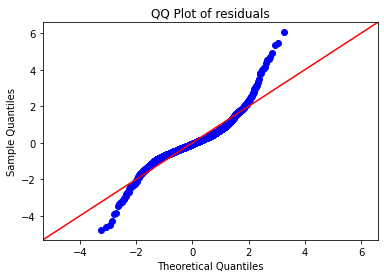


Mean squared error: 476.5s
Mean error: 21.8s

Max p: weight p=0.055


In [132]:
model_name = "3rd_order_4"
drop += ["result_1"]

do_linear_regression(pp_row, model_name, target, order=3, drop=drop)

3rd_order_5


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1003.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:21   Log-Likelihood:                -7975.7
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1774   BIC:                         1.605e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3818.8688   1764.

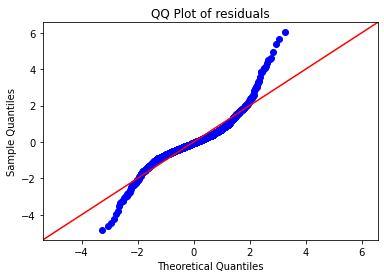


Mean squared error: 476.6s
Mean error: 21.8s

Max p: weight_3 p=0.396


In [133]:
model_name = "3rd_order_5"
drop += ["weight"]

do_linear_regression(pp_row, model_name, target, order=3, drop=drop)

3rd_order_6


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1095.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:36:22   Log-Likelihood:                -7976.0
No. Observations:                1787   AIC:                         1.598e+04
Df Residuals:                    1775   BIC:                         1.604e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3757.3739   1762.

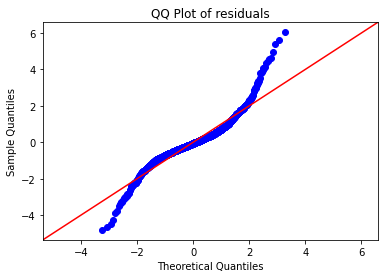


Mean squared error: 479.7s
Mean error: 21.9s

Max p: Intercept p=0.033


In [134]:
model_name = "3rd_order_6"
drop += ["weight_3"]

do_linear_regression(pp_row, model_name, target, order=3, drop=drop)

3rd_order_6


                                 OLS Regression Results                                
Dep. Variable:            result_2000   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          8.294e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):                        0.00
Time:                        09:36:55   Log-Likelihood:                         -7978.3
No. Observations:                1787   AIC:                                  1.598e+04
Df Residuals:                    1776   BIC:                                  1.604e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------

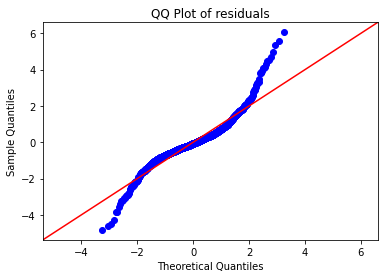


Mean squared error: 479.9s
Mean error: 21.9s

Max p: age p=0.005


In [136]:
model_name = "3rd_order_7"
intercept=False

do_linear_regression(pp_row, model_name, target, order=3, drop=drop, intercept=intercept)

3rd_order_6


                                 OLS Regression Results                                
Dep. Variable:            result_2000   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          9.089e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):                        0.00
Time:                        09:37:24   Log-Likelihood:                         -7982.2
No. Observations:                1787   AIC:                                  1.598e+04
Df Residuals:                    1777   BIC:                                  1.604e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------

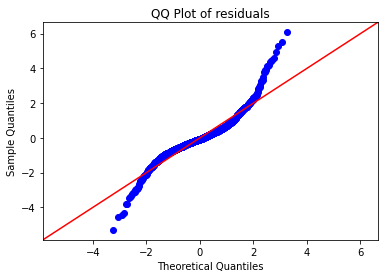


Mean squared error: 476.6s
Mean error: 21.8s

Max p: age_2 p=0.225


In [137]:
model_name = "3rd_order_8"
drop+=["age"]

do_linear_regression(pp_row, model_name, target, order=3, drop=drop, intercept=intercept)

3rd_order_9


                                 OLS Regression Results                                
Dep. Variable:            result_2000   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.010e+05
Date:                Tue, 06 Apr 2021   Prob (F-statistic):                        0.00
Time:                        09:38:37   Log-Likelihood:                         -7983.0
No. Observations:                1787   AIC:                                  1.598e+04
Df Residuals:                    1778   BIC:                                  1.603e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------

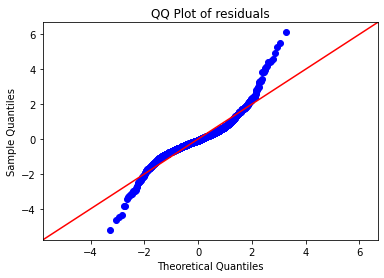


Mean squared error: 477.5s
Mean error: 21.9s

Max p: height_3 p=0.0


In [139]:
model_name = "3rd_order_9"
drop+=["age_2"]

do_linear_regression(pp_row, model_name, target, order=3, drop=drop, intercept=intercept)

# Comparison with Paul's Law

For every doubling of distance, add 5 seconds to the 500m split pace

In [140]:
def pauls_law_1km_2km(time_known):
    return (time_known/2 + 5) * 4

In [141]:
df_pl = pp_row.df_val.copy()

df_pl["result_2000_pred"] = df_pl["result_1000"].apply(pauls_law_1km_2km)
df_pl["squared_error"] = (df_pl["result_2000"] - df_pl["result_2000_pred"])**2
mse = df_pl["squared_error"].mean()
rmse = np.sqrt(df_pl["squared_error"].mean())

In [142]:
print(f"Mean squared error: {round(mse,1)}s")
print(f"Mean error: {round(rmse,1)}s")

Mean squared error: 583.9s
Mean error: 24.2s


# Comparison with using a single result for prediction

1000_only


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 1.079e+04
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:01:27   Log-Likelihood:                -8065.5
No. Observations:                1787   AIC:                         1.614e+04
Df Residuals:                    1785   BIC:                         1.615e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      67.2195      3.946     

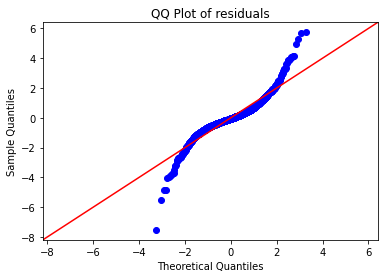


Mean squared error: 552.8s
Mean error: 23.5s

Max p: Intercept p=0.0


In [149]:
model_name = "1000_only"
intercept = True
drop = ["result_1", "age", "height", "weight", "gender"]

do_linear_regression(pp_row, model_name, target, order=1, drop=drop, intercept=intercept)

1000_only_sq


                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     5489.
Date:                Tue, 06 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:02:25   Log-Likelihood:                -8051.5
No. Observations:                1787   AIC:                         1.611e+04
Df Residuals:                    1784   BIC:                         1.613e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -47.5073     21

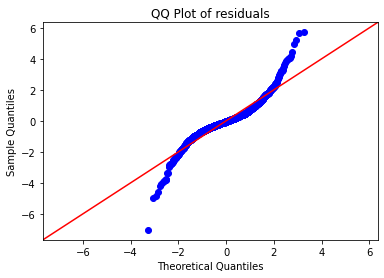


Mean squared error: 545.3s
Mean error: 23.4s

Max p: Intercept p=0.03


In [152]:
model_name = "1000_only_sq"
drop += ["result_1_2", "age_2", "height_2", "weight_2", "gender_2"]
do_linear_regression(pp_row, model_name, target, order=2, drop=drop, intercept=intercept)

# Logarathmic Transformation

The non-normality of residuals suggests we have problems with the model. We have already removed outliers and tried plotting higher order models but the residuals remain non-normal.

We will first try a logarathmic transformation of the target variable.



In [157]:
file_path = "./"
file_name = "cleaned_data.csv"

pp_log = pp.Predictor(f"{file_path}{file_name}", random_state=42)

target = ["result_2000"]
predictor_results = ["result_1", "result_1000"]
core_columns = ["age", "height", "weight", "weight_class", "gender"]

columns = target + predictor_results + core_columns

pp_log.df = pp_log.df[columns]

#drop nulls
indexes_to_drop = []
for col in columns:
    indexes_to_drop_temp = pp_log.df[pp_log.df[col].isnull()].index.to_list()
    #if len(indexes_to_drop_temp) > 0:
    indexes_to_drop += indexes_to_drop_temp

pp_log.df = pp_log.df.drop(indexes_to_drop)

In [158]:
pp_log.df

result_2000  result_1  result_1000  age  height  weight weight_class  \
10           388.7     337.0        190.1   48   185.4    93.0            H   
17           387.3     345.0        187.9   45   185.4    73.9            L   
37           664.5     209.0        328.6   82   157.5    68.0            H   
53           468.0     309.0        215.6   58   180.3    79.4            H   
64           587.9     258.0        275.8   71   180.3    88.0            H   
...            ...       ...          ...  ...     ...     ...          ...   
60080        710.5     238.0        353.4   36   162.6    77.1            H   
60342        474.0     298.0        228.9   71   193.0    87.5            H   
60344        529.1     285.0        260.8   61   180.3    90.3            H   
60393        517.6     291.0        243.7   61   182.9   113.9            H   
60451        632.5     292.0        276.3   42   182.9   113.4            H   

      gender  
10         M  
17         M  
37         F  
53         M  
64         M  
...      ...  
60080      F  
60342      M  
60344      M  
60393      M  
60451      M  

[2553 rows x 8 columns]

In [ ]:
pp_log.df["result_2000"] = np.log()